## Importing all necessary libraries

In [13]:
import cv2 # to work with images
import pandas as pd # to work with dataframes
import re # to use regular expressions
import matplotlib.pyplot as plt # to plot the graphs
import os # to use operating system function
import time #to use for time delays
import numpy as np #to use numerical calculations
from datetime import datetime #library to get time and date
import sqlite3 #to handle database management

## Defining Face Recognition class

In [14]:
class FaceRecognizer: #define a class for Face Recognition
    def __init__(self,thresold=0.5,draw=True): #Initialize the class 
        self.thresold=thresold # set the thresold for face recognition
        self.draw=draw # set the draw flag to draw the rectangle on face
        self.unknownmatch=0 #initialize the unknown match counter to 0 
        detector_weights ="model/face_detection_yunet_2023mar.onnx"  #face detection model path
        self.face_detector = cv2.FaceDetectorYN_create(detector_weights, "", (0, 0)) # fit the detection weights
        self.face_detector.setScoreThreshold(0.87) # set the score thresold for detection 
        recogniser_weights = "model/face_recognizer_fast.onnx" #face recognition model path
        self.face_recognizer = cv2.FaceRecognizerSF_create(recogniser_weights, "") # fit the recognition weights
        self.create_feature() #calling the function to crate the face features
    def create_feature(self): #method to create the face features from the registered images 
        self.dictionary = {} #initialize the dictionary to store the features of registered images 
        files=os.listdir("images") #list of all images that is registered already
        files = list(set(files))# make a set to avoid duplicates
        for file in files:
            image = cv2.imread("images/"+file) # read the image from the folder images by using cv2 
            feats, faces = self.recognize_face(image, file) #extract features from the image
            if faces is None: # if no face is detected in the image then skip the image
                continue
            user_id = os.path.splitext(os.path.basename(file))[0] #extracting user name from image
            self.dictionary[user_id] = feats[0] # add data to dictionary
    def recognize_face(self,image,file_name=None): # method to recognize the face from 
        channels = 1 if len(image.shape) == 2 else image.shape[2] #detect the number of channels in the image
        if channels == 1: #if the image is in gray scale then convert it to BGR
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # change color to BGR
        if channels == 4: #if the image is in BGRA then convert it to BGR
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) # change color to BGR
        if image.shape[0] > 1000: #if the image is bigger than 1000 then resize it to 500
            image = cv2.resize(image, (0, 0),
                            fx=500 / image.shape[0], fy=500 / image.shape[0]) # resize image to fit into the model
        height, width, _ = image.shape #get the height and width of the image
        self.face_detector.setInputSize((width, height)) #set the input size of the model
        try: # try to detect the face in the image
            dts = time.time() #get the current time
            _, faces = self.face_detector.detect(image) #detect the face in the image
            if file_name is not None: #if the file name is not none then check if the face is detected or not
                assert len(faces) > 0, f'the file {file_name} has no face' #if no face is detected then raise an error
            faces = faces if faces is not None else [] #if no face is detected then set the faces to empty list
            features = [] #initialize the feature list
            for face in faces: #loop through all faces
                rts = time.time() #get the current time 
                aligned_face = self.face_recognizer.alignCrop(image, face) # align and crop the face
                feat = self.face_recognizer.feature(aligned_face) #extract the features from the face
                features.append(feat) #append the features to the list
            return features, faces #return the features and faces
        except Exception as e: #if any exception occurs then print the error
            return None, None 
    def match(self, feature1): # method to match the face with register faces
        max_score = 0.0 #initialize the score
        sim_user_id = "" #initialize the user id
        for user_id, feature2 in zip(self.dictionary.keys(), self.dictionary.values()): #loop through all registered users
            score = self.face_recognizer.match(feature1, feature2, cv2.FaceRecognizerSF_FR_COSINE) #calculate similarity
            if score >= max_score: #if the score is greater than max score then update the max score and user id
                max_score = score #update the max score
                sim_user_id = user_id #update the user id
        if max_score < self.thresold: #if the score is less than thresold then return false
            return False, ("", 0.0) #return false
        return True, (sim_user_id, max_score) #return true and user id and score
    def detect(self,image): #method to detect the image
        fetures, faces = self.recognize_face(image) #extract features from new images
        id_name="Unknown" #Initialize the id_name as Unknown
        id_name_list=[] #initialize the id_name_list as empty list
        if faces is not None: # loop throgh all faces
            for idx, (face, feature) in enumerate(zip(faces, fetures)): #loop through all faces and features in enumerate form
                result, user = self.match(feature) #calling match function
                box = list(map(int, face[:4])) # extract the boundix box to draw a rectangle
                color = (0, 255, 0) if result else (0, 0, 255) #chose color green or red
                id_name, score = user if result else (f"Unknown", 0.0) #if result is true then get the user name and score
                id_name_list.append(id_name) # appending all recognised name in a list
                info = "{0} ({1:.2f})".format(id_name, score) #make infromation to display
                position = (box[0], box[1]) #get the position of the box
                font = cv2.FONT_HERSHEY_SIMPLEX #define font to show
                cv2.rectangle(image,position,(position[0]+170,position[1]-25),(0,0,0),-1) #draw a rectangle to to show the name
                cv2.rectangle(image, box, color, 4, cv2.LINE_AA) #draw a rectangle on face
                cv2.putText(image, info , (position[0],position[1]-10), font, 0.6,
                            color, 2, cv2.LINE_AA) #write text on screen
        return id_name #return the name of the recognised person

Cleanup completed.


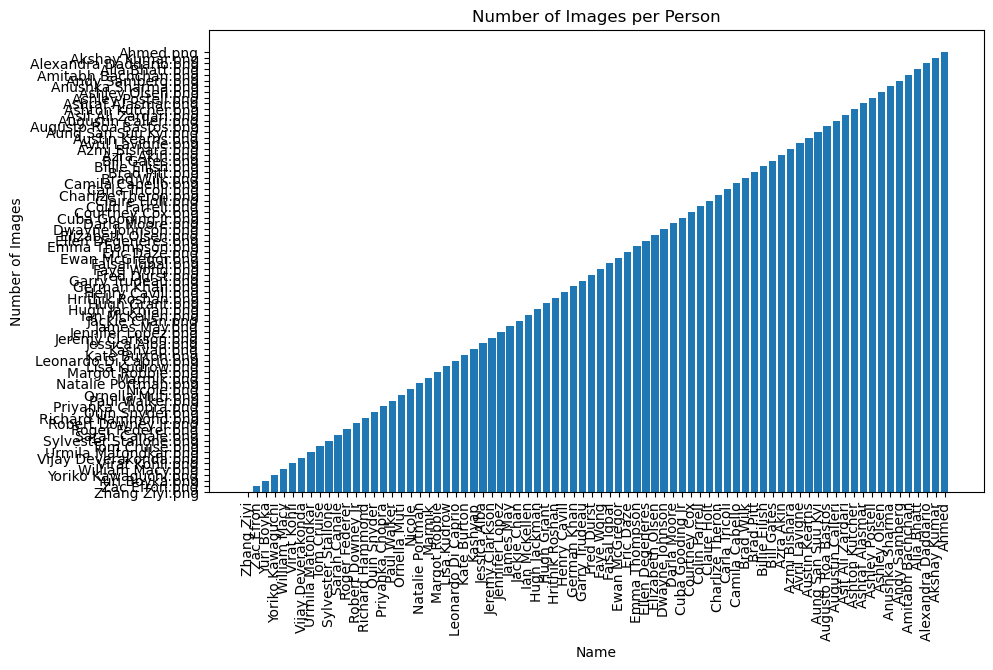

In [15]:
image_dir = r'images' #definning the image directory
files = os.listdir(image_dir) #list all the files in the directory
pattern = re.compile(r"^(.*?)(\d*)\.png$") #pattern to match the file name and extension
first_occurrence = {} # Dictionary to keep track of the first occurrence of each person
for filename in files:
    if filename.endswith('.png'):
        match = pattern.match(filename) # Match the pattern with the filename
        if match:
            name = match.group(1) # Extract the name from the filename
            if name not in first_occurrence:
                first_occurrence[name] = filename # Record the first occurrence of this name
            else:
                os.remove(os.path.join(image_dir, filename)) # Delete the duplicate file
                print(f"Deleted duplicate: {filename}")
print("Cleanup completed.")
df_counts = pd.DataFrame(list(first_occurrence.items()), columns=['Name', 'Count']) # Convert to DataFrame for easy plotting
df_counts.sort_values(by='Count', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
plt.bar(df_counts['Name'], df_counts['Count'])
plt.xlabel('Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Person')
plt.xticks(rotation=90)
plt.show()

## Defining the database management class

In [16]:
class DBManager: # defining the database amangement class
    def __init__(self, dbname="system/Database.db"): #initialize the class
        if not os.path.exists("system/"): #check if the system folder exists or not
            os.mkdir("system/") #if not then create the folder
        self.dbname = dbname #set the database name
        if not os.path.exists(self.dbname): #check if the database exists or not
            self.con = sqlite3.connect(self.dbname) #conncting to database
            self.cursor = self.con.cursor() #creating cursor
            self.create_table_attendance() #calling funtion to create attendance table
            self.close_connection()#closing database connection
    def close_connection(self): #method to close the database connection
        try: #try to close the connection
            self.con.close()
        except: #if any exception occurs then pass the exception
            pass    
    def create_table_attendance(self): #method to create attendance table in database
        command = '''CREATE TABLE Attendance(ID INTEGER PRIMARY KEY ,UserName TEXT,Date TEXT,Time TEXT)'''
        try:
            self.cursor.execute(command)
            self.con.commit()
        except:
            pass
    def insert_into_attendance(self, name,cdate,ctime): #method to insert data into attendance
        self.con = sqlite3.connect(self.dbname) #connect to database
        cursor = self.con.cursor() #create cursor
        command_insertvalue = "insert into Attendance (UserName,Date,Time) values (?, ?,?)" #command to insert data
        try:
            cursor.execute(command_insertvalue,(name,cdate, ctime))
            self.con.commit()
            self.close_connection()
        except Exception as e:
            print(e)
    def get_last_entry_time(self, name,cdate): #Method to get the last entry time of the student
        self.con = sqlite3.connect(self.dbname)
        cursor = self.con.cursor()
        command = "SELECT * FROM Attendance WHERE (UserName) = ? and (Date)=? " #command to get the last entry time
        cursor.execute(command, (name,cdate)) # execute the command
        rows = cursor.fetchall() #fetch all the data from the database
        if rows: #if the data is present then get the last entry time
            row = rows[-1] #get the last row
            time = row[3] #get the time
            minute=time.split(":")[1] #get the minute
            return minute #return the minute of the last entry
        return "63" #if no entry is present then return 63 as minute

### Function to get current date and time

In [17]:
def get_current_datetime(): #function to get current date and time
    cdate=datetime.now().strftime("%Y-%m-%d") # current date
    ctime=datetime.now().strftime("%H:%M:%S") #current time
    return cdate,ctime

### Making a function to authenticate user

In [18]:
def authenticate_user(face_recognizer,image): #funtion to authenticate user
    name=face_recognizer.detect(image)
    if name !='Unknown':
        return name
    return None

### code to execute the authentication process

In [19]:
image=cv2.imread('testimage.png') #geting the test image
face_recognizer=FaceRecognizer() #instanciate the face recognition class
authenticated_user=authenticate_user(face_recognizer,image) #calling authentiction function
if authenticated_user:
    print(f"Access granted to {authenticated_user}")
    print(f"Welcome {authenticated_user}")
else:
    print("Access denied")

Access granted to Ahmed
Welcome Ahmed


### function to autheticate payment

In [20]:
def authenticate_payment(face_recognizer,image,pname,pay_amount): #funtion to authenticate user
    name=face_recognizer.detect(image)
    if name ==pname: #check if name is same 
        print(f'User authorized. {pay_amount} EGP transfered to {pname} Successfully')
    else:
        print('Unauthorized user detected')
        print("Payment failed")

### code to execute the payment authentication

In [21]:
recognizer=FaceRecognizer()#instanciate the face recognition class
image=cv2.imread('testimage.png') #geting the test image
name='Ahmed' #define name
amount=500 #set payment amount
authenticate_payment(face_recognizer,image,name,amount) # authenticate the payment with parameters name and amount

User authorized. 500 EGP transfered to Ahmed Successfully


### Function to take attendance

In [22]:
def take_attendance():
    recognizer=FaceRecognizer() #instanciate the face recognition class
    dbmanager=DBManager()#instanciate the databsemanager
    cap = cv2.VideoCapture(0) #open the webcam, usually the webcam id is 0 but sometimes it may be 1 or 2
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    while True:
        _,frame=cap.read() #read the frame from the webcam
        name=recognizer.detect(frame) #detect the face in the frame
        if name!='Unknown': #if the name is not unknown then insert the data into the database
            cdate,ctime=get_current_datetime() #get the current date and time 
            last_entry=dbmanager.get_last_entry_time(name,cdate) #get the last entry time
            last_minute=datetime.now().strftime("%M") #strf does the formating of the time
            if last_minute!=last_entry: #if the last entry minute is not equal to the current minute then insert the data
                dbmanager.insert_into_attendance(name,cdate,ctime)  #insert the data into the database
        cv2.imshow('image',frame)
        key=cv2.waitKey(1)
        if key==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
take_attendance() # calling the function to take attendance, open webcam and capture the data and insert the data into the database